In [43]:
import numpy as np
import time
import cv2
from kalman_filter.EKF import ExtendedKalmanFilter
from kalman_filter.kalman import kalman_filter
import dependencies.constants_robot as cst
import matplotlib.pyplot as plt

In [44]:
def f(x, dt):
    angle = x[2]
    dcosA = dt*np.cos(angle)
    dsinA = dt*np.sin(angle)

    # f(x) = x @ self.f
    f = np.array([
                    [      1,       0,     0, 0, 0],
                    [      0,       1,     0, 0, 0],
                    [      0,       0,     1, 0, 0],
                    [dcosA/2, dsinA/2,  -dt/cst.L, 1, 0],
                    [dcosA/2, dsinA/2, dt/cst.L, 0, 1]])
    x_update = x @ f
    return x_update

In [45]:
x_ini = np.array([0, 0, 0, 0, 0])
dt = 0.1
left_wheel =  np.concatenate(([10]*10, [10]*10, [5]*10, [10]*10))
right_wheel = np.concatenate(([10]*10, [5]*10, [10]*10, [10]*10))

In [46]:
position = np.zeros((len(left_wheel), 3))
x_update = x_ini
for i in range(len(left_wheel)-1):
    x_current = x_update
    x_current[3] = left_wheel[i]
    x_current[4] = right_wheel[i]
    x_update = f(x_current, dt)
    position[i+1] = x_update[0:3]

In [47]:
# simulate noises on the position
position_wheel_noisy = position.copy()
left_wheel_noisy = left_wheel + np.random.normal(0, 0.01, len(left_wheel))
right_wheel_noisy = right_wheel + np.random.normal(0, 0.01, len(left_wheel))
x_update = x_ini
for i in range(len(left_wheel)-1):
    x_current = x_update
    x_current[3] = left_wheel_noisy[i]
    x_current[4] = right_wheel_noisy[i]
    x_update = f(x_current, dt)
    position_wheel_noisy[i+1] = x_update[0:3]

In [48]:
# do the kalman filter
position_noisy = position.copy()
position_noisy[1:, 0] += np.random.normal(0, 0.01, len(left_wheel)-1)
position_noisy[1:, 1] += np.random.normal(0, 0.01, len(left_wheel)-1)
position_filtered = np.zeros((len(left_wheel), 3))
ekf = ExtendedKalmanFilter(x_ini[0:3])
x_update = x_ini
for i in range(len(left_wheel)):
    x_update, kidnapping = kalman_filter(ekf, position_noisy[i], np.array([left_wheel_noisy[i], right_wheel_noisy[i]]))
    position_filtered[i] = x_update[0:3]

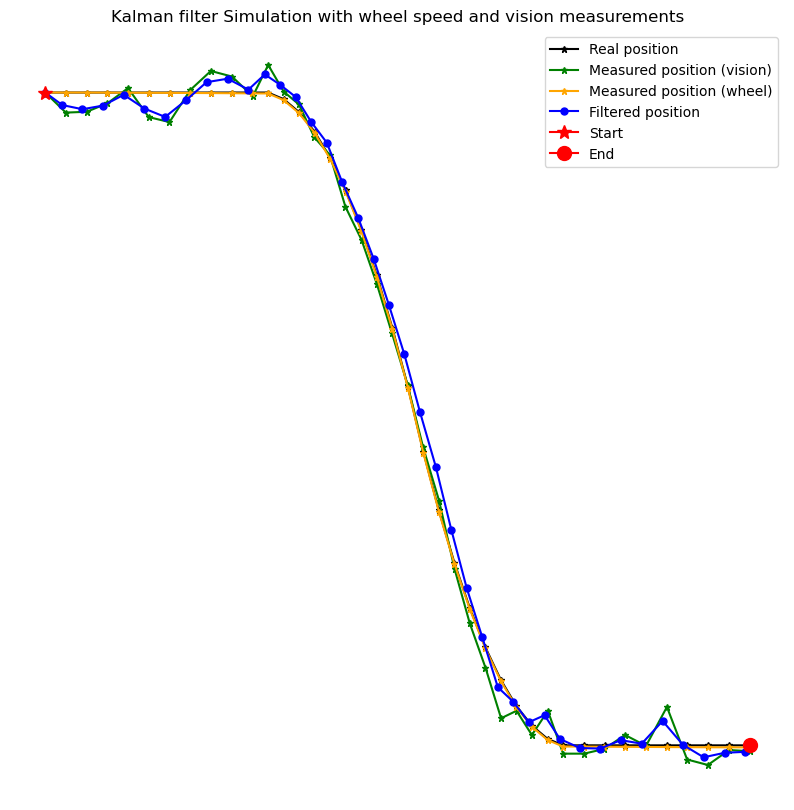

In [49]:
plt.style.use('default')
plt.figure(figsize=(10,10))
plt.plot(position[:,0], position[:,1], marker='*', markersize=5, color="black", label="Real position")
plt.plot(position_noisy[:,0], position_noisy[:,1], marker='*', markersize=5, color="green", label="Measured position (vision)")
plt.plot(position_wheel_noisy[:,0], position_wheel_noisy[:,1], marker='*', markersize=5, color="orange", label="Measured position (wheel)")
plt.plot(position_filtered[:,0], position_filtered[:,1], marker='o', markersize=5, color="blue", label="Filtered position")
plt.plot(position[0,0], position[0,1], marker='*', markersize=10, color="red", label="Start")
plt.plot(position[-1,0], position[-1,1], marker='o', markersize=10, color="red", label="End")
plt.axis('off')
plt.title("Kalman filter Simulation with wheel speed and vision measurements")
plt.legend()